In [8]:
# Reprodutibilidade da Atividade Prática
# Executa criação, join, limpeza, análises e gráficos
import sqlite3, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
sql_path = Path("data/scripts_atividade.sql")
with open(sql_path, "r", encoding="utf-8") as f:
    sql_script = f.read()

conn = sqlite3.connect(":memory:")
cur = conn.cursor()
cur.executescript(sql_script)
conn.commit()

In [11]:
sql_join = """SELECT
  v.id_venda,
  v.id_produto,
  p.nome_produto,
  p.categoria,
  p.preco_unitario,
  v.quantidade,
  v.data_venda,
  v.desconto
FROM vendas v
LEFT JOIN produtos p
  ON v.id_produto = p.id_produto
ORDER BY v.id_venda;"""
df = pd.read_sql(sql_join, conn)
df["data_venda"] = pd.to_datetime(df["data_venda"], errors="coerce")
df["quantidade"] = df["quantidade"].fillna(0).astype(int)
df["desconto"]   = df["desconto"].fillna(0.0)
df["categoria"]  = df["categoria"].fillna("Sem categoria")
df["tem_produto"] = ~df["id_produto"].isna()
df["preco_faltante"] = df["preco_unitario"].isna()
df["subtotal"] = df["preco_unitario"] * df["quantidade"]
df["valor_total"] = (df["subtotal"].fillna(0) - df["desconto"]).clip(lower=0)

df.to_csv("vendas_produtos_limpo.csv", index=False, encoding="utf-8")

In [12]:
faturamento_categoria = (df.groupby("categoria")["valor_total"].sum().reset_index())
faturamento_por_dia = (df.groupby("data_venda")["valor_total"].sum().reset_index())

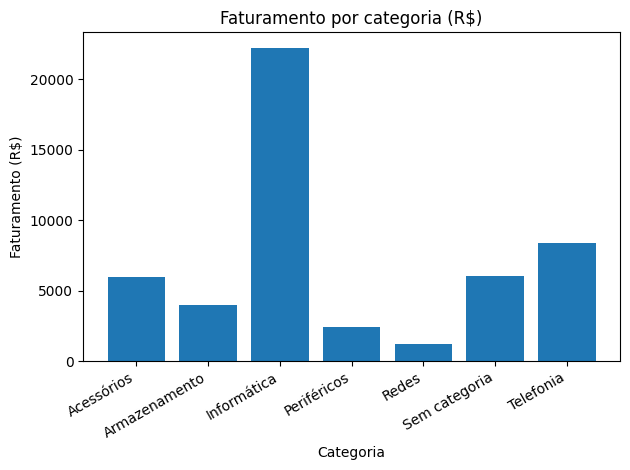

In [15]:
plt.figure()
plt.bar(faturamento_categoria["categoria"], faturamento_categoria["valor_total"])
plt.title("Faturamento por categoria (R$)")
plt.xlabel("Categoria"); plt.ylabel("Faturamento (R$)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("grafico_faturamento_categoria.png", dpi=150, bbox_inches="tight")


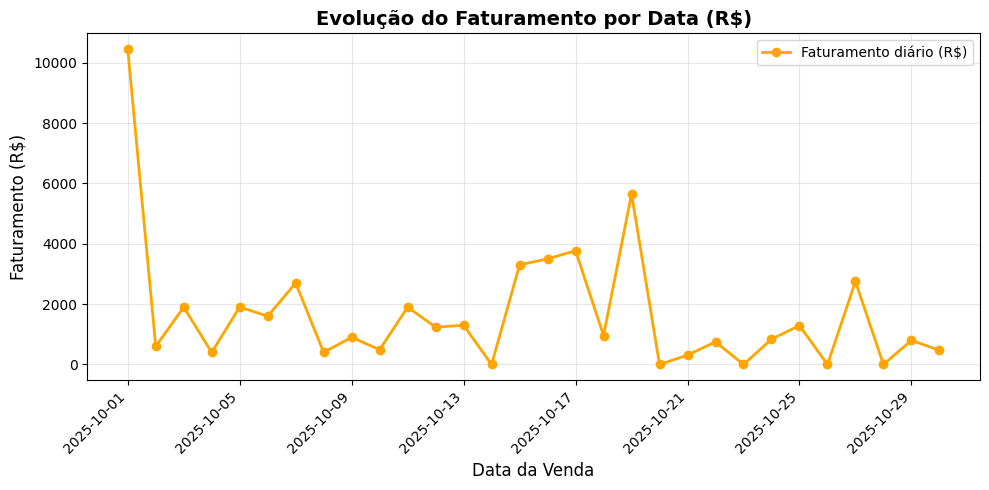

In [16]:
plt.figure(figsize=(10,5))
plt.plot(
    faturamento_por_dia["data_venda"],
    faturamento_por_dia["valor_total"],
    marker='o',
    color='orange',
    linewidth=2,
    label='Faturamento diário (R$)'
)

# Ajustes visuais simples — sem mdates
plt.xticks(rotation=45, ha='right')        # gira as datas
plt.title("Evolução do Faturamento por Data (R$)", fontsize=14, weight='bold')
plt.xlabel("Data da Venda", fontsize=12)
plt.ylabel("Faturamento (R$)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()